## Load libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import os
import gensim
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pd.options.mode.chained_assignment = None  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhaolongjiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load/Clean data

In [2]:
us = pd.read_excel('/Users/zhaolongjiang/Desktop/US_tweet_data (1).xlsx')
us.head()## Load/Clean data

,Tweets,Time,Account,Likes,Hashtag,Unnamed: 5,sentiment
0,Immigration remains the top issue among SC pri...,Feb 24,@IzzyLyman,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN
1,Here is Del. Alfonso López speaking about two ...,Feb 15,@LatinoCaucusVA,"5 replies, 6 reposts, 4 likes, 503 views",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN
2,Don’t let the Left gaslight you \n\nIt’s norma...,Feb 27,@JesseHughesNC,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN
3,"Sometimes, unbearable horrors and cruel twists...",Feb 19,@KiddieChronicle,"2 reposts, 35 likes, 496 views",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN
4,Your Party members have called out the BS with...,Feb 24,@IamAmericasidea,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN


In [3]:
us_cleaned = us.drop_duplicates(subset = ['Tweets', 'Account', 'Likes'], keep = 'last')
us_cleaned.shape

(12849, 7)

In [4]:
us_cleaned.loc[:,'Region'] = us_cleaned['Hashtag'].apply(lambda x: x.upper()[:2])
us_cleaned.head()

,Tweets,Time,Account,Likes,Hashtag,Unnamed: 5,sentiment,Region
0,Immigration remains the top issue among SC pri...,Feb 24,@IzzyLyman,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN,US
1,Here is Del. Alfonso López speaking about two ...,Feb 15,@LatinoCaucusVA,"5 replies, 6 reposts, 4 likes, 503 views",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN,US
2,Don’t let the Left gaslight you \n\nIt’s norma...,Feb 27,@JesseHughesNC,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN,US
3,"Sometimes, unbearable horrors and cruel twists...",Feb 19,@KiddieChronicle,"2 reposts, 35 likes, 496 views",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN,US
4,Your Party members have called out the BS with...,Feb 24,@IamAmericasidea,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",us since:2024-02-01 until:2024-02-29 immigration,NaN,NaN,US


In [6]:
us_cleaned.loc[:,'Month'] = us_cleaned['Hashtag'].apply(lambda x: x[9:16])
us_cleaned = us_cleaned.drop(columns = 'Hashtag')
us_cleaned['Likes'] = us_cleaned['Likes'].fillna('none')
us_cleaned.head()

,Tweets,Time,Account,Likes,Unnamed: 5,sentiment,Region,Month
0,Immigration remains the top issue among SC pri...,Feb 24,@IzzyLyman,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",NaN,NaN,US,2024-02
1,Here is Del. Alfonso López speaking about two ...,Feb 15,@LatinoCaucusVA,"5 replies, 6 reposts, 4 likes, 503 views",NaN,NaN,US,2024-02
2,Don’t let the Left gaslight you \n\nIt’s norma...,Feb 27,@JesseHughesNC,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",NaN,NaN,US,2024-02
3,"Sometimes, unbearable horrors and cruel twists...",Feb 19,@KiddieChronicle,"2 reposts, 35 likes, 496 views",NaN,NaN,US,2024-02
4,Your Party members have called out the BS with...,Feb 24,@IamAmericasidea,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",NaN,NaN,US,2024-02


In [8]:
us_cleaned.to_csv('/Users/zhaolongjiang/Desktop/US_tweet_data.csv', index = False)

## Analysis

### Influence

In [9]:
repost_filter = us_cleaned['Likes'].str.contains('repost')### Influence
us_cleaned.loc[repost_filter, 'Reposts'] = us_cleaned.loc[repost_filter, 'Likes'].apply(lambda x: re.findall('(\d+[.,]?\d*)(?:[\s\d\-\+\/]*)(?:repost)', x)[0]).astype('int')   
us_cleaned.loc[~repost_filter, 'Reposts'] = 0
us_cleaned[['Likes', 'Reposts']].head(10)## Analysis

<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
/var/folders/mm/vz00s87d5831dtr_qcjg3ln00000gn/T/ipykernel_87909/1985288720.py:2: DeprecationWarning: invalid escape sequence '\d'
  us_cleaned.loc[repost_filter, 'Reposts'] = us_cleaned.loc[repost_filter, 'Likes'].apply(lambda x: re.findall('(\d+[.,]?\d*)(?:[\s\d\-\+\/]*)(?:repost)', x)[0]).astype('int')


,Likes,Reposts
0,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",4.0
1,"5 replies, 6 reposts, 4 likes, 503 views",6.0
2,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",3.0
3,"2 reposts, 35 likes, 496 views",2.0
4,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",55.0
5,"5 reposts, 11 likes, 2 bookmarks, 1178 views",5.0
6,"3 replies, 4 reposts, 26 likes, 252 views",4.0
7,"27 replies, 276 reposts, 427 likes, 4 bookmark...",276.0
8,"7 replies, 30 reposts, 129 likes, 8586 views",30.0
9,"16 replies, 105 reposts, 327 likes, 3 bookmark...",105.0


In [10]:
print(len(us_cleaned[us_cleaned.Reposts >= 10]))
us_cleaned['Influential'] = np.where(us_cleaned.Reposts >= 10, 'yes', 'no')
us_cleaned.head()

2083


,Tweets,Time,Account,Likes,Unnamed: 5,sentiment,Region,Month,Reposts,Influential
0,Immigration remains the top issue among SC pri...,Feb 24,@IzzyLyman,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",NaN,NaN,US,2024-02,4.0,no
1,Here is Del. Alfonso López speaking about two ...,Feb 15,@LatinoCaucusVA,"5 replies, 6 reposts, 4 likes, 503 views",NaN,NaN,US,2024-02,6.0,no
2,Don’t let the Left gaslight you \n\nIt’s norma...,Feb 27,@JesseHughesNC,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",NaN,NaN,US,2024-02,3.0,no
3,"Sometimes, unbearable horrors and cruel twists...",Feb 19,@KiddieChronicle,"2 reposts, 35 likes, 496 views",NaN,NaN,US,2024-02,2.0,no
4,Your Party members have called out the BS with...,Feb 24,@IamAmericasidea,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",NaN,NaN,US,2024-02,55.0,yes


### Sentiment and topic, Overall

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    res = [[word for word in simple_preprocess(str(doc)) 
             if (word not in stop_words) & (word not in ['https', 'com'])] for doc in texts]
    return res

data = us_cleaned.Tweets.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])### Sentiment and topic, Overall

['immigration', 'remains', 'top', 'issue', 'among', 'sc', 'primary', 'voters', 'stoptheinvasion']


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [13]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha = 'symmetric',
                                       eta = 'auto',
                                       random_state = 9)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]#### Sentiment analysis

[(0,
  '0.042*"immigration" + 0.009*"illegal" + 0.008*"border" + 0.006*"people" + '
  '0.005*"biden" + 0.004*"laws" + 0.004*"us" + 0.004*"new" + 0.004*"get" + '
  '0.003*"years"'),
 (1,
  '0.048*"immigration" + 0.008*"border" + 0.005*"illegal" + 0.003*"get" + '
  '0.003*"people" + 0.003*"status" + 0.003*"new" + 0.003*"trump" + '
  '0.003*"like" + 0.003*"immigrants"'),
 (2,
  '0.056*"immigration" + 0.007*"illegal" + 0.006*"us" + 0.005*"people" + '
  '0.005*"biden" + 0.004*"like" + 0.004*"reform" + 0.004*"policy" + '
  '0.004*"need" + 0.003*"country"')]


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.015176  0.026351       1        1  40.615471
1     -0.017539 -0.025112       2        1  30.210636
0      0.032715 -0.001239       3        1  29.173893, topic_info=        Term         Freq        Total Category  logprob  loglift
71    border  1278.000000  1278.000000  Default  30.0000  30.0000
326  illegal  1629.000000  1629.000000  Default  29.0000  29.0000
277    great   213.000000   213.000000  Default  28.0000  28.0000
879     laws   602.000000   602.000000  Default  27.0000  27.0000
192      try   196.000000   196.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
191     time   142.272995   457.773394   Topic3  -6.1588   0.0633
222      one   151.782212   604.489321   Topic3  -6.0941  -0.1500
779     want   145.491522   568.806125   Topic3  -6.1364  -0.1315
129   policy   144.481888   668.861030   Topic3  -6.1434  -0.3005
88      need   143.365239   664.945658   Topic3  -6.1511  -0.3024

[293 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1886       1  0.148773        able
1886       2  0.582696        able
1886       3  0.260353        able
10169      1  0.867995  activation
392        1  0.027209     afremov
...      ...       ...         ...
6609       1  0.866890  最高峰マウスか新発売
1010       2  0.886174      画像タッフて
1010       3  0.088617      画像タッフて
1011       2  0.887517   選手かいち早く体感
1011       3  0.133127   選手かいち早く体感

[515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

#### Sentiment analysis

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def tweet_sentiment(tweet):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(tweet)
    return ss['compound']

us_cleaned['Sentiment'] = us_cleaned['Tweets'].apply(tweet_sentiment)
us_cleaned.head()#### Sentiment analysis

,Tweets,Time,Account,Likes,Unnamed: 5,sentiment,Region,Month,Reposts,Influential,Sentiment
0,Immigration remains the top issue among SC pri...,Feb 24,@IzzyLyman,"1 reply, 4 reposts, 27 likes, 1 bookmark, 745 ...",NaN,NaN,US,2024-02,4.0,no,0.2714
1,Here is Del. Alfonso López speaking about two ...,Feb 15,@LatinoCaucusVA,"5 replies, 6 reposts, 4 likes, 503 views",NaN,NaN,US,2024-02,6.0,no,0.0000
2,Don’t let the Left gaslight you \n\nIt’s norma...,Feb 27,@JesseHughesNC,"2 replies, 3 reposts, 14 likes, 1 bookmark, 68...",NaN,NaN,US,2024-02,3.0,no,0.7783
3,"Sometimes, unbearable horrors and cruel twists...",Feb 19,@KiddieChronicle,"2 reposts, 35 likes, 496 views",NaN,NaN,US,2024-02,2.0,no,-0.2960
4,Your Party members have called out the BS with...,Feb 24,@IamAmericasidea,"6 replies, 55 reposts, 215 likes, 2 bookmarks,...",NaN,NaN,US,2024-02,55.0,yes,0.6476


<Axes: >

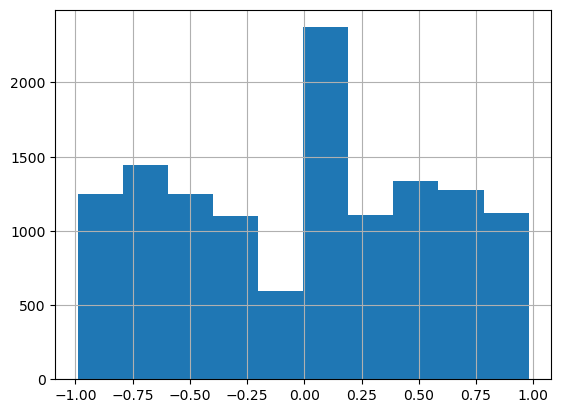

In [17]:
us_cleaned['Sentiment'].hist()

Topical sentiment

In [18]:
def topic_classify(text, lda_model):
    #clean_text = remove_stopwords(sent_to_words(text))
    clean_text = text.split()
    new_text_corpus =  id2word.doc2bow(clean_text)
    lda_res = lda_model[new_text_corpus]
    res = max(lda_res, key=lambda item: item[1])[0]
    return 'topic ' + str(res)Topical sentiment

In [19]:
us_cleaned['topic_class'] = us_cleaned['Tweets'].apply(lambda x: topic_classify(x, lda_model))
us_cleaned['topic_class'].value_counts()

topic_class
topic 2    5405
topic 0    3809
topic 1    3635
Name: count, dtype: int64

In [20]:
topic_pct = us_cleaned.groupby('topic_class')['Sentiment'].apply(lambda x: [100*(x<0).sum()/len(x), 100*(x==0).sum()/len(x), 100*(x>0).sum()/len(x)])
topic_dict = topic_pct.to_dict()
topic_dict

{'topic 0': [42.84589131005513, 16.80231031766868, 40.351798372276185],
 'topic 1': [43.053645116918844, 13.039889958734525, 43.90646492434663],
 'topic 2': [45.328399629972246, 11.859389454209065, 42.81221091581869]}

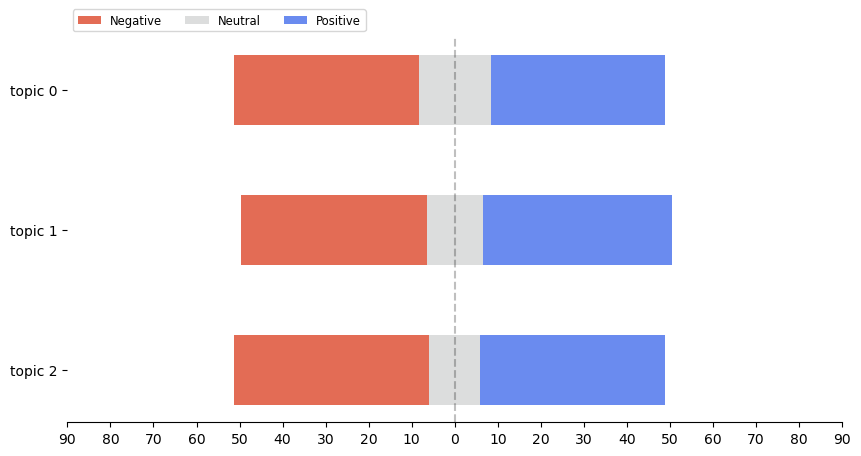

In [21]:
import matplotlib.pyplot as plt

category_names = ['Negative', 'Neutral', 'Positive']
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-90, 90)
    ax.set_xticks(np.arange(-90, 91, 10))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(topic_pct.to_dict(), category_names)
plt.show()

### Sentiment and topic, influence

In [22]:
inf_data = us_cleaned[us_cleaned.Influential == 'yes'].Tweets.values.tolist()
inf_words = list(sent_to_words(data))
# remove stop words
inf_words = remove_stopwords(inf_words)
print(inf_words[:1][0][:30])### Sentiment and topic, influence

['immigration', 'remains', 'top', 'issue', 'among', 'sc', 'primary', 'voters', 'stoptheinvasion']


In [23]:
import gensim.corpora as corpora
# Create Dictionary
inf_id2word = corpora.Dictionary(inf_words)
# Create Corpus
inf_texts = inf_words
# Term Document Frequency
inf_corpus = [id2word.doc2bow(text) for text in inf_texts]
# View
print(inf_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [24]:
from pprint import pprint
# number of topics
inf_num_topics = 3
# Build LDA model
inf_lda_model = gensim.models.LdaMulticore(corpus=inf_corpus,
                                       id2word=inf_id2word,
                                       num_topics=inf_num_topics,
                                       alpha = 'symmetric',
                                       eta = 'auto',
                                       random_state = 9)
# Print the Keyword in the 10 topics
pprint(inf_lda_model.print_topics())
inf_doc_lda = inf_lda_model[inf_corpus]

[(0,
  '0.042*"immigration" + 0.009*"illegal" + 0.008*"border" + 0.006*"people" + '
  '0.005*"biden" + 0.004*"laws" + 0.004*"us" + 0.004*"new" + 0.004*"get" + '
  '0.003*"years"'),
 (1,
  '0.048*"immigration" + 0.008*"border" + 0.005*"illegal" + 0.003*"get" + '
  '0.003*"people" + 0.003*"status" + 0.003*"new" + 0.003*"trump" + '
  '0.003*"like" + 0.003*"immigrants"'),
 (2,
  '0.056*"immigration" + 0.007*"illegal" + 0.006*"us" + 0.005*"people" + '
  '0.005*"biden" + 0.004*"like" + 0.004*"reform" + 0.004*"policy" + '
  '0.004*"need" + 0.003*"country"')]


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
inf_LDAvis_data_filepath = os.path.join('inf_ldavis_prepared_'+str(inf_num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    inf_LDAvis_prepared = pyLDAvis.gensim.prepare(inf_lda_model, inf_corpus, inf_id2word)
    with open(inf_LDAvis_data_filepath, 'wb') as f:
        pickle.dump(inf_LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(inf_LDAvis_data_filepath, 'rb') as f:
    inf_LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(inf_LDAvis_prepared, 'inf_ldavis_prepared_'+ str(inf_num_topics) +'.html')
inf_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.015176  0.026351       1        1  40.615472
1     -0.017539 -0.025112       2        1  30.210635
0      0.032715 -0.001239       3        1  29.173892, topic_info=        Term         Freq        Total Category  logprob  loglift
71    border  1278.000000  1278.000000  Default  30.0000  30.0000
326  illegal  1629.000000  1629.000000  Default  29.0000  29.0000
277    great   213.000000   213.000000  Default  28.0000  28.0000
879     laws   602.000000   602.000000  Default  27.0000  27.0000
192      try   196.000000   196.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
191     time   142.272992   457.773431   Topic3  -6.1588   0.0633
222      one   151.782209   604.489296   Topic3  -6.0941  -0.1500
779     want   145.491534   568.806120   Topic3  -6.1364  -0.1315
129   policy   144.481884   668.861079   Topic3  -6.1434  -0.3005
88      need   143.365236   664.945661   Topic3  -6.1511  -0.3024

[293 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1886       1  0.148773        able
1886       2  0.582696        able
1886       3  0.260353        able
10169      1  0.867995  activation
392        1  0.027209     afremov
...      ...       ...         ...
6609       1  0.866890  最高峰マウスか新発売
1010       2  0.886174      画像タッフて
1010       3  0.088617      画像タッフて
1011       2  0.887517   選手かいち早く体感
1011       3  0.133127   選手かいち早く体感

[515 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [26]:
inf_sent = us_cleaned.loc[us_cleaned.Influential == 'yes', 'Tweets'].apply(tweet_sentiment)

<Axes: >

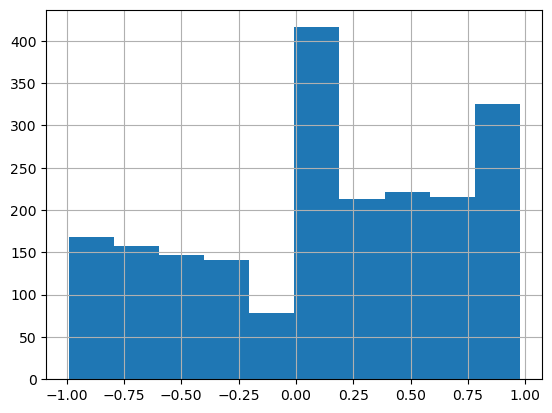

In [27]:
inf_sent.hist()

In [29]:
us_inf = us_cleaned[us_cleaned.Influential == 'yes']
us_inf['inf_topic_class'] = us_inf['Tweets'].apply(lambda x: topic_classify(x, inf_lda_model))
us_inf['inf_topic_class'].value_counts()

inf_topic_class
topic 2    759
topic 0    741
topic 1    583
Name: count, dtype: int64

In [30]:
inf_topic_pct = us_inf.groupby('topic_class')['Sentiment'].apply(lambda x: [100*(x<0).sum()/len(x), 100*(x==0).sum()/len(x), 100*(x>0).sum()/len(x)])
inf_topic_dict = inf_topic_pct.to_dict()
inf_topic_dict

{'topic 0': [29.071332436069987, 21.130551816958278, 49.79811574697174],
 'topic 1': [37.54325259515571, 17.82006920415225, 44.63667820069204],
 'topic 2': [33.98950131233596, 11.15485564304462, 54.85564304461942]}

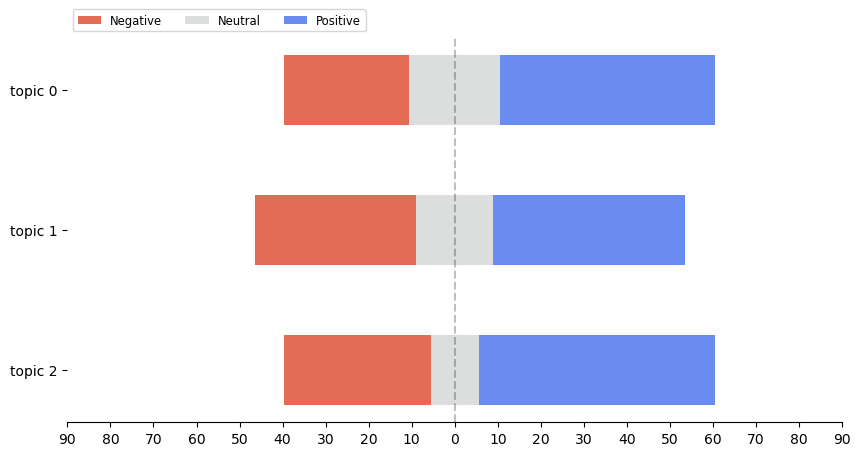

In [31]:
fig, ax = survey(inf_topic_dict, category_names)
plt.show()